# Use of Transfer Learning and Large Language Models methods: TCR-BERT 

### First exploration of TCR-BERT

In [1]:
# Different model classes needed for different models
from transformers import BertModel
# This model was pretrained on MAA and TRB classification
tcrbert_model = BertModel.from_pretrained("wukevin/tcr-bert")

In [2]:
import model_utils  # found under the "tcr" folder

# Load a TextClassificationPipeline using TCR-BERT
tcrbert_trb_cls = model_utils.load_classification_pipeline("wukevin/tcr-bert", device=-1) # device=0 if cuda is available
# For the pipeline, input amino acids are expected to be spaced
results = model_utils.reformat_classification_pipeline_preds(tcrbert_trb_cls([
    "C A S S P V T G G I Y G Y T F",  # Binds to NLVPMVATV CMV antigen
    "C A T S G R A G V E Q F F",      # Binds to GILGFVFTL flu antigen
]))  # Return a dataframe where each column is an antigen, each row corresponds to an input

In [3]:
# get highest probability antigen
results.idxmax(axis=1)

0    NLVPMVATV
1    GILGFVFTL
dtype: object

### Application to our dataset to perform prediction (without finetuning) and evaluation of its **raw** performance 

In [2]:
import pandas as pd
df = pd.read_csv('./peptide-detail-ci_filtered_aligned_merged.csv')
df["Amino Acids 1"] = df["Amino Acids"].apply(lambda x: x.split(",")[0])
df.head()

,CDR3,CDR3_al,tokenized_smiles,TCR BioIdentity,TCR Nucleotide Sequence,Experiment,ORF Coverage,Amino Acids,Start Index in Genome,End Index in Genome,v_gene,j_gene,Amino Acids 1
0,CASSAQGTGDRGYTF,CASSA-----QGTGDRGYTF,"[12, 16, 34, 34, 31, 31, 31, 31, 31, 27, 13]",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,GAGTCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCA...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ01-02,ADAGFIKQY
1,CASSLVATGNTGELFF,CASSL----VATGNTGELFF,"[12, 16, 34, 34, 31, 31, 31, 31, 23, 27, 27, 13]",CASSLVATGNTGELFF+TCRBV07-09+TCRBJ02-02,CGCACAGAGCAGGGGGACTCGGCCATGTATCTCTGTGCCAGCAGCT...,eOX56,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV07-09,TCRBJ02-02,ADAGFIKQY
2,CALKVGADTQYF,CALKV--------GADTQYF,"[12, 16, 31, 31, 31, 31, 31, 31, 31, 31, 27, 13]",CALKVGADTQYF+TCRBV30-01+TCRBJ02-03,CTGAGTTCTAAGAAGCTCCTTCTCAGTGACTCTGGCTTCTATCTCT...,eQD124,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV30-01,TCRBJ02-03,ADAGFIKQY
3,CASSLWASGRGGTGELFF,CASSLW--ASGRGGTGELFF,"[12, 16, 34, 34, 31, 31, 34, 27, 27, 13]",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,AGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTTTATGGG...,eAV93,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-02,ADAGFIKQY
4,CASSLLGWEQLDEQFF,CASSL----LGWEQLDEQFF,"[12, 16, 34, 34, 31, 31, 31, 31, 27, 27, 13]",CASSLLGWEQLDEQFF+TCRBV27-01+TCRBJ02-01,TCGCCCAGCCCCAACCAGACCTCTCTGTACTTCTGTGCCAGCAGTT...,eMR16,"ORF1ab,surface glycoprotein","ADAGFIKQY,AELEGIQY,LADAGFIKQY,TLADAGFIK",533,24073,TCRBV27-01,TCRBJ02-01,ADAGFIKQY


In [5]:
df_unique = df.drop_duplicates(subset=['CDR3'])
df_unique.reset_index(inplace=True, drop=True)

In [6]:
# Count the number of occurences of each antigen
print(df_unique["Amino Acids 1"].value_counts())
# select only antigens with between 1000 and 5000 occurences
df_unique_balanced = df_unique[df_unique["Amino Acids 1"].isin(df_unique["Amino Acids 1"].value_counts().index[(df_unique["Amino Acids 1"].value_counts() > 2000) & (df_unique["Amino Acids 1"].value_counts() < 5000)])]
print(len(df_unique_balanced))
print(len(df_unique_balanced["Amino Acids 1"].unique()))

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


AFLLFLVLI        11320
HTTDPSFLGRY       8916
FVDGVPFVV         4379
FLWLLWPVT         4126
KLSYGIATV         3656
                 ...  
ASFNYLKSPNFSK        2
IITTDNTFV            2
YQKVGMQKY            2
SSRGTSPAR            2
LMIERFVSL            1
Name: Amino Acids 1, Length: 269, dtype: int64
29119
9


In [10]:
N = 1000
store = []
true_labels = []
for i in range(N):
    # Change format, by putting spaces between each letter in CDR3
    cdr3 = df_unique["CDR3"][i]
    cdr3 = " ".join(cdr3)
    store.append(cdr3)
    true_labels.append(df_unique["Amino Acids 1"][i])

results = model_utils.reformat_classification_pipeline_preds(tcrbert_trb_cls(store))  # Return a dataframe where each column is an antigen, each row corresponds to an input
print(len(store))

1000


In [11]:
N = 1000
sample_unique_balanced = df_unique_balanced.sample(N)
store_balanced = []
true_labels_balanced = []
for i in range(N):
    # Change format, by putting spaces between each letter in CDR3
    cdr3 = sample_unique_balanced["CDR3"].iloc[i]
    cdr3 = " ".join(cdr3)
    store_balanced.append(cdr3)
    true_labels_balanced.append(sample_unique_balanced["Amino Acids 1"].iloc[i])

results_balanced = model_utils.reformat_classification_pipeline_preds(tcrbert_trb_cls(store_balanced))  # Return a dataframe where each column is an antigen, each row corresponds to an input

In [22]:
preds = results.idxmax(axis=1)
preds_unique = results.idxmax(axis=1).unique()

Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


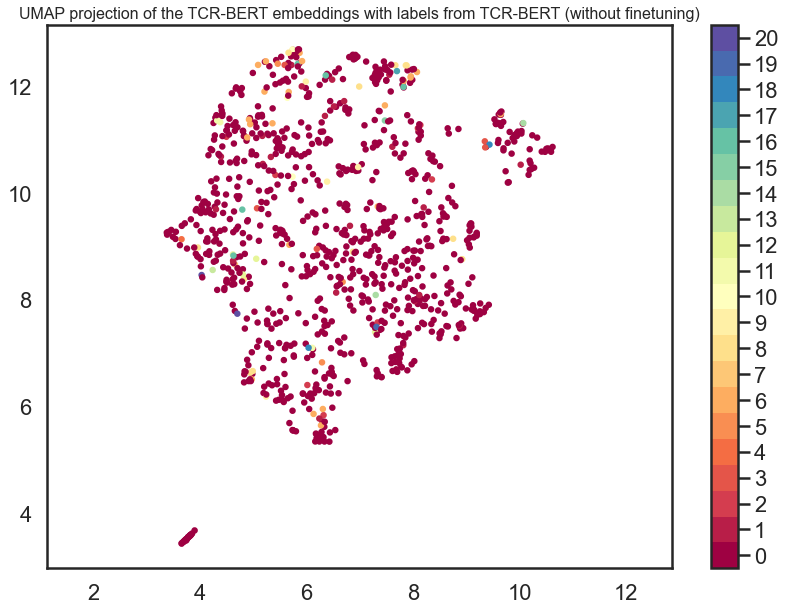

In [18]:
embeddings = model_utils.get_transformer_embeddings(
            model_dir="wukevin/tcr-bert",
            seqs=store,
            layers=[-7],
            method="mean",
            device=3,
        )

# use UMAP to reduce dimensionality
import umap
reducer = umap.UMAP(random_state=42)
embedding_umap = reducer.fit_transform(embeddings)

# Associate each prediction with a number for plotting
preds_color = []
for i in range(len(preds)):
    preds_color.append(list(preds_unique).index(preds[i]))

# plot with labels as colors 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=preds_color, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(preds_unique)+1)-0.5).set_ticks(np.arange(len(preds_unique)))
plt.title('UMAP projection of the TCR-BERT embeddings with labels from TCR-BERT (without finetuning)', fontsize=16);
plt.show()



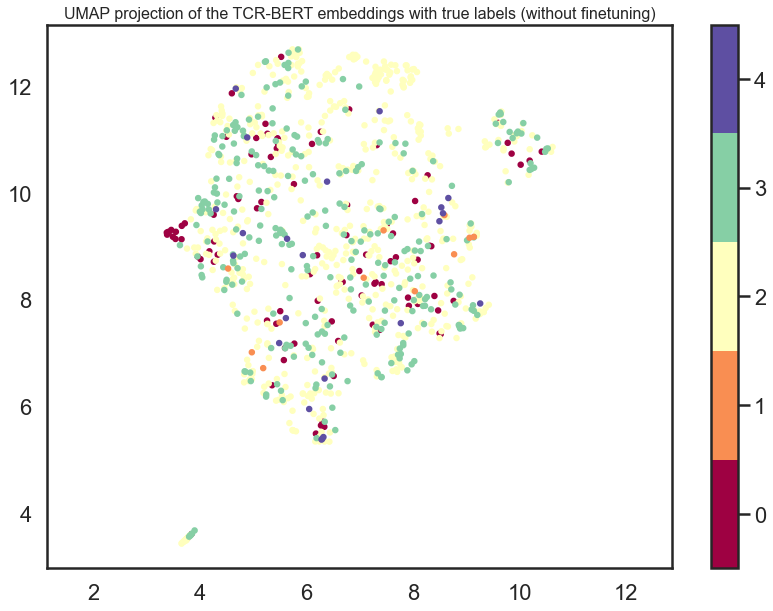

In [19]:
# get unique of true labels
true_labels_unique = np.unique(true_labels)

# Associate each prediction with a number for plotting
true_labels_color = []
for i in range(len(true_labels)):
    true_labels_color.append(list(true_labels_unique).index(true_labels[i]))

# plot with labels as colors 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=true_labels_color, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(true_labels_unique)+1)-0.5).set_ticks(np.arange(len(true_labels_unique)))
plt.title('UMAP projection of the TCR-BERT embeddings with true labels (without finetuning)', fontsize=16);
plt.show()


Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


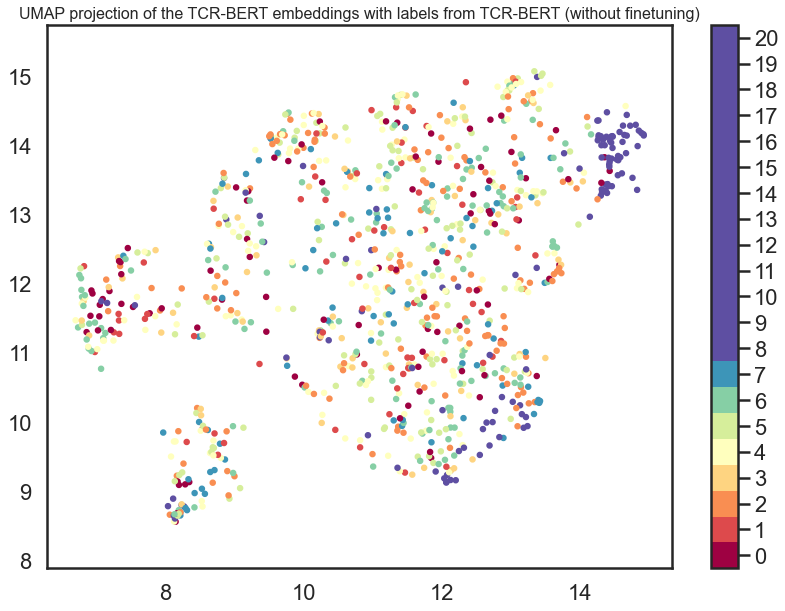

In [24]:
embeddings = model_utils.get_transformer_embeddings(
            model_dir="wukevin/tcr-bert",
            seqs=store_balanced,
            layers=[-7],
            method="mean",
            device=3,
        )

# use UMAP to reduce dimensionality
import umap
reducer = umap.UMAP(random_state=42)
embedding_umap = reducer.fit_transform(embeddings)

true_labels_balanced_unique = np.unique(true_labels_balanced)
# Associate each prediction with a number for plotting
true_labels_balanced_color = []
for i in range(len(true_labels_balanced)):
    true_labels_balanced_color.append(list(true_labels_balanced_unique).index(true_labels_balanced[i]))

# plot with labels as colors 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=true_labels_balanced_color, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(preds_unique)+1)-0.5).set_ticks(np.arange(len(preds_unique)))
plt.title('UMAP projection of the TCR-BERT embeddings with labels from TCR-BERT (without finetuning)', fontsize=16);
plt.show()



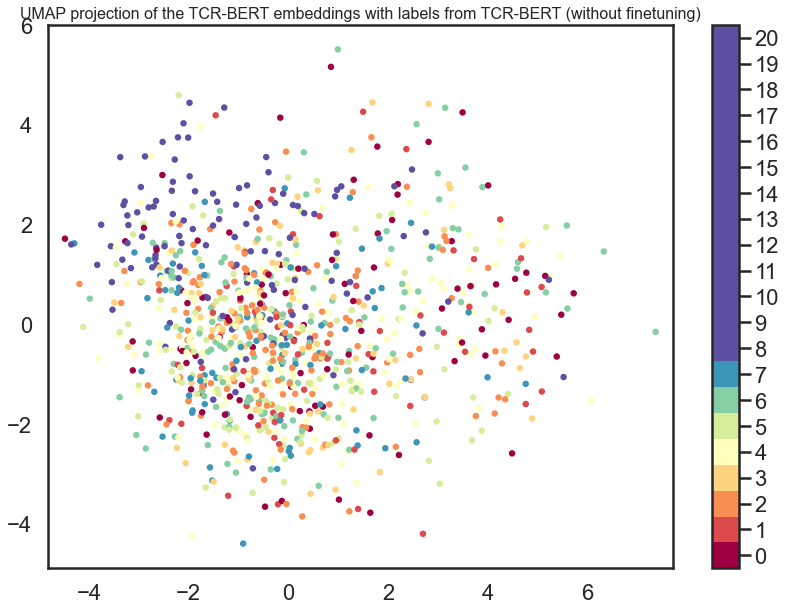

In [26]:
# use PCA to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embeddings)



true_labels_balanced_unique = np.unique(true_labels_balanced)
# Associate each prediction with a number for plotting
true_labels_balanced_color = []
for i in range(len(true_labels_balanced)):
    true_labels_balanced_color.append(list(true_labels_balanced_unique).index(true_labels_balanced[i]))

# plot with labels as colors 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], c=true_labels_balanced_color, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(preds_unique)+1)-0.5).set_ticks(np.arange(len(preds_unique)))
plt.title('PCA projection of the TCR-BERT embeddings with labels from TCR-BERT (without finetuning)', fontsize=16);
plt.show()



In [17]:
df_unique_antigen = df.drop_duplicates(subset=['Amino Acids 1'])
df_unique_antigen.reset_index(inplace=True, drop=True)

In [26]:
N = len(df_unique_antigen)
store = []
true_labels = []
for i in range(N):
    # Change format, by putting spaces between each letter in CDR3
    cdr3 = df_unique_antigen["CDR3"][i]
    cdr3 = " ".join(cdr3)
    store.append(cdr3)
    true_labels.append(df_unique_antigen["Amino Acids 1"][i])

results = model_utils.reformat_classification_pipeline_preds(tcrbert_trb_cls(store))  # Return a dataframe where each column is an antigen, each row corresponds to an input

In [34]:
# Associate each prediction with a number for plotting
true_labels_color = []
for i in range(len(true_labels)):
    true_labels_color.append(list(true_labels_unique).index(true_labels[i]))
print(len(true_labels_color))

269


Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


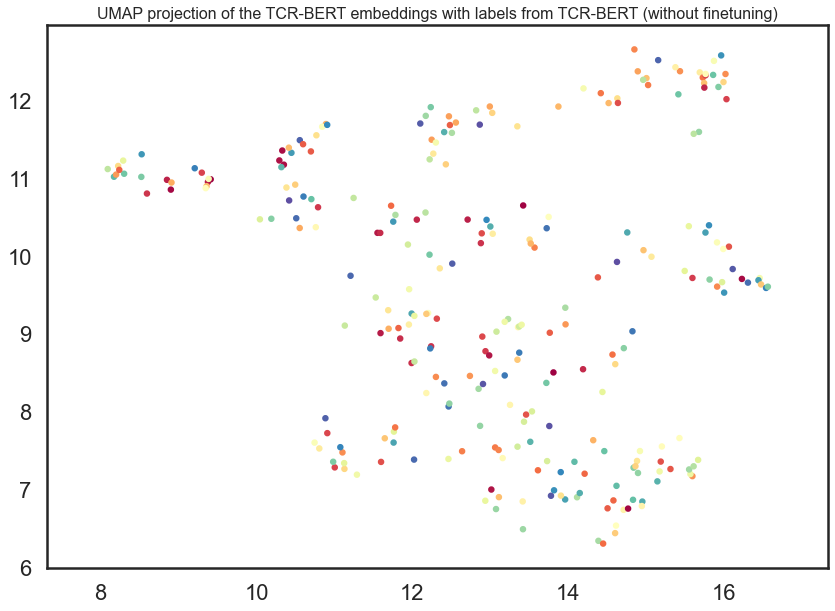

In [29]:
embeddings = model_utils.get_transformer_embeddings(
            model_dir="wukevin/tcr-bert",
            seqs=store,
            layers=[-7],
            method="mean",
            device=3,
        )

# use UMAP to reduce dimensionality
import umap
reducer = umap.UMAP(random_state=42)
embedding_umap = reducer.fit_transform(embeddings)

# plot with labels as colors 
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=true_labels_color, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the TCR-BERT embeddings with labels from TCR-BERT (without finetuning)', fontsize=16);
plt.show()



Some weights of the model checkpoint at wukevin/tcr-bert were not used when initializing BertModel: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


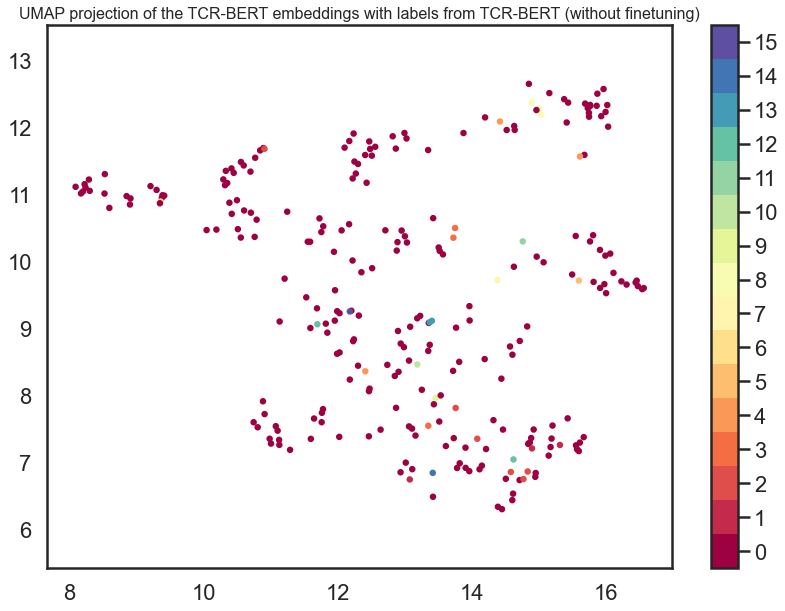

In [19]:
preds = results.idxmax(axis=1)
preds_unique = results.idxmax(axis=1).unique()

embeddings = model_utils.get_transformer_embeddings(
            model_dir="wukevin/tcr-bert",
            seqs=store,
            layers=[-7],
            method="mean",
            device=3,
        )

# use UMAP to reduce dimensionality
import umap
reducer = umap.UMAP(random_state=42)
embedding_umap = reducer.fit_transform(embeddings)

# Associate each prediction with a number for plotting
preds_color = []
for i in range(len(preds)):
    preds_color.append(list(preds_unique).index(preds[i]))

# plot with labels as colors 
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=preds_color, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(len(preds_unique)+1)-0.5).set_ticks(np.arange(len(preds_unique)))
plt.title('UMAP projection of the TCR-BERT embeddings with labels from TCR-BERT (without finetuning)', fontsize=16);
plt.show()



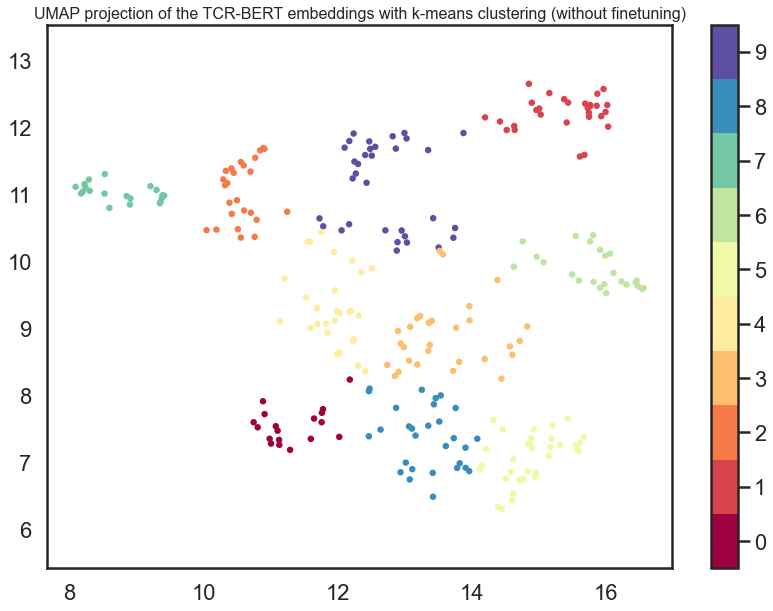

In [20]:
# Perform k-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(embedding_umap)
kmeans.labels_

# plot with labels as colors
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
plt.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=kmeans.labels_, s=20, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the TCR-BERT embeddings with k-means clustering (without finetuning)', fontsize=16);
plt.show()

INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/LastResort.otf: tuple indices must be integers or slices, not str
INFO:matplotlib.font_manager:Failed to extract font properties from /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


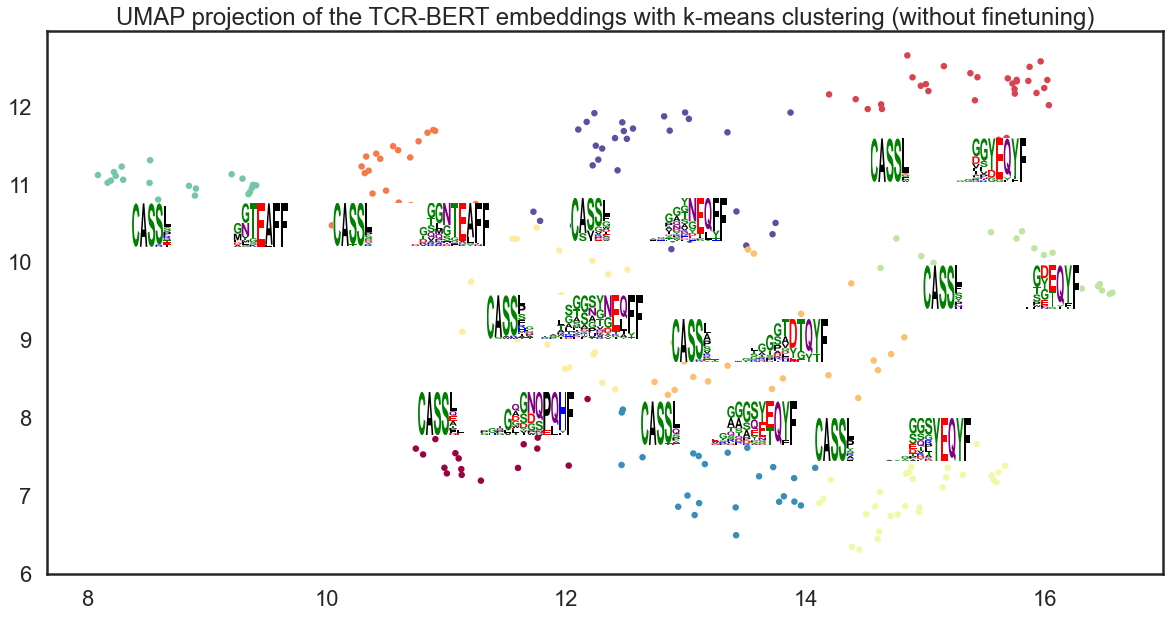

In [21]:
# add small plots to big plot for labels of groups 
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

# Perform k-means clustering
from sklearn.cluster import KMeans
import pyrepseq as rs
import pyrepseq.plotting as rsp
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding_umap)

# plot with labels as colors
fig = plt.figure(figsize=(20,10))
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
ax = fig.add_subplot(111)
ax.scatter(embedding_umap[:, 0], embedding_umap[:, 1], c=kmeans.labels_, s=20, cmap='Spectral')
ax.set_title('UMAP projection of the TCR-BERT embeddings with k-means clustering (without finetuning)', fontsize=24);


for k in range(n_clusters):
    # Select only the rows with the k means group k
    df_unique_antigen_k = df_unique_antigen[kmeans.labels_ == k]
    # get coordinate of center of cluster 
    center = kmeans.cluster_centers_[k]
    # plot small plots by specifying size of axes
    subax1 = add_subplot_axes(ax, [center[0]/10-0.8, center[1]/10-0.5, 0.14, 0.08])
    rsp.seqlogos(df_unique_antigen_k["CDR3_al"], ax=subax1)

plt.show()

### Fine-tuning of TCR-BERT on our dataset and evaluation of its **fine-tuned** performance

In [5]:
# sample 1000 rows 
df_sample = df.drop_duplicates(subset=['CDR3'])
print(len(df_sample))
df_sample = df_sample.sample(n=100000, random_state=1)
df_sample.reset_index(inplace=True, drop=True)
# Rename 'CDR3' to 'TRB' 
df_sample.rename(columns={'CDR3': 'TRB'}, inplace=True)
# Rename 'Amino Acids 1' to 'label'
df_sample.rename(columns={'Amino Acids 1': 'label'}, inplace=True)

110301


In [6]:
# Save cdr3 and labels as tsv file 
df_sample[["TRB", "label"]].to_csv("tcrbert_trb_cls_100k.tsv", sep="\t", index=False)

In [1]:
"""
Finetune transformer that accepts a SINGLE input (either TRA or TRB)
as opposed to two inputs (i.e. TRA and TRB) (see finetune_transformer.py)
"""

### Useful links:
### https://huggingface.co/transformers/custom_datasets.html

from enum import unique
import os, sys
import logging
import json
import itertools
import argparse
from typing import *

import tqdm

import numpy as np
import pandas as pd
from sklearn import metrics
from scipy.special import softmax

import torch
import torch.nn as nn
from torch.utils.data import Dataset

import skorch
import skorch.helper
import neptune

from transformers import (
    BertForSequenceClassification,
    BertConfig,
    BertTokenizer,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction,
    EarlyStoppingCallback,
)

import git
import data_loader as dl
import featurization as ft
import model_utils
import utils
from transformer_custom import BertForSequenceClassificationMulti

logging.basicConfig(level=logging.INFO)

METRICS = []  # Global tracker for metrics states


def sigmoid(x):
    """Sigmoid"""
    return 1 / (1 + np.exp(-x))


def compute_metrics(pred: EvalPrediction) -> Dict[str, float]:
    """Compute binary metrics to report"""
    labels = pred.label_ids
    labels_expanded = np.zeros(pred.predictions.shape)
    labels_expanded[np.arange(labels.size), labels.squeeze()] += 1
    preds = pred.predictions.argmax(-1)
    preds_probs = softmax(pred.predictions, axis=1)
    if preds_probs.shape[1] == 2:
        preds_probs = preds_probs[:, 1:]
        labels_expanded = labels_expanded[:, 1:]
    assert (
        labels_expanded.shape == preds_probs.shape
    ), f"Got differing shapes: {labels_expanded.shape} {preds_probs.shape}"
    acc = metrics.accuracy_score(labels, preds)

    # Compute averages per category
    auroc_values, auprc_values = [], []
    for i in range(preds_probs.shape[-1]):
        l = labels_expanded[:, i]
        p = preds_probs[:, i]
        if len(np.unique(l)) < 2:
            continue
        auroc_values.append(metrics.roc_auc_score(l, p))
        auprc_values.append(metrics.average_precision_score(l, p))

    # Update global metrics tracker
    global METRICS
    METRICS.append(
        {"auroc_per_label": auroc_values, "auprc_per_label": auprc_values,}
    )

    auroc = np.mean(auroc_values)
    auprc = np.mean(auprc_values)
    return {
        "accuracy": acc,
        "auroc": auroc,
        "auprc": auprc,
    }


def compute_metrics_multi(pred: EvalPrediction) -> Dict[str, float]:
    """Compute multi-label metrics"""
    labels = pred.label_ids
    preds = pred.predictions
    preds_sigmoid = sigmoid(preds)
    assert labels.shape == preds.shape == preds_sigmoid.shape
    # For both, this calculates per-class metric and averages across classes
    auroc_values, auprc_values, used_classes, pos_rate = [], [], [], []
    for j in range(labels.shape[1]):
        if len(set(labels[:, j])) == 1:  # These are undefined
            continue
        used_classes.append(j)
        auroc = metrics.roc_auc_score(
            labels[:, j], preds_sigmoid[:, j], average="macro"
        )
        auprc = metrics.average_precision_score(
            labels[:, j], preds_sigmoid[:, j], average="macro"
        )
        auroc_values.append(auroc)
        auprc_values.append(auprc)
        pos_rate.append(float(np.mean(labels[:, j])))
    METRICS.append(
        {
            "auroc_per_label": auroc_values,
            "auprc_per_label": auprc_values,
            "pos_per_class": pos_rate,
            "used_classes": used_classes,
        }
    )
    return {"auroc": np.mean(auroc_values), "auprc": np.mean(auprc_values)}


def load_data_single(
    keyword: Literal["lcmv", "vdjdb", "pird", "covid", "nsclc"],
    segment: Literal["TRB", "TRA"] = "TRB",
) -> List[Tuple[str, str]]:
    """
    Load the data
    Returns pairs of (antigen, seq) or more generally (label, seq)
    Comma (,) can be included in antigen/label string to indicate multi-label
    Antigen/label can also be empty string to indicate multi-label
    """
    logging.info(f"Loading {keyword} {segment} data")
    assert segment == "TRA" or segment == "TRB"
    if keyword.lower() == "lcmv":
        if segment != "TRB":
            raise NotImplementedError
        lcmv_data = dl.load_lcmv_table()
        lcmv_trb, lcmv_labels = dl.dedup_lcmv_table_trb_only(lcmv_data)
        lcmv_labels = np.array(
            ["TetPos" in t or "TetMid" in t for t in lcmv_data["tetramer"]]
        )
        lcmv_antigen = [
            lcmv_data.iloc[i]["antigen.sequence"] if lcmv_labels[i] else ""
            for i in range(len(lcmv_data))
        ]
        return list(zip(lcmv_antigen, lcmv_trb))
    elif keyword.lower() == "vdjdb":  # Evey sequence here has a corresponding epitope
        vdjdb_tab = dl.load_vdjdb(tra_trb_filter=[segment])
        vdjdb_antigens = vdjdb_tab["antigen.epitope"]
        vdjdb_aa = vdjdb_tab["cdr3"]
        return list(zip(vdjdb_antigens, vdjdb_aa))
    elif keyword.lower() == "pird":
        tcr_key = f"CDR3.{'beta' if segment == 'TRB' else 'alpha'}.aa"
        pird_tab = dl.load_pird(with_antigen_only=True)
        pird_tab_tcr_nonnull = pird_tab.loc[~pd.isnull(pird_tab[tcr_key])]
        pird_antigens = pird_tab_tcr_nonnull["Antigen.sequence"]
        pird_tcrs = pird_tab_tcr_nonnull[tcr_key]
        logging.info(
            f"Loaded PIRD {segment} dataset with {len(pird_tcrs)} antigen-TCR pairs"
        )
        return list(zip(pird_antigens, pird_tcrs))
    elif keyword.lower() == "covid":
        if segment == "TRA":
            raise NotImplementedError
        logging.info("Loading immuneACCESS SARS-CoV-2 TRBs with TCRdb background")
        covid_table = dl.load_immuneaccess_mira_covid()
        covid_trbs = list(covid_table["TCR_aa"])
        covid_antigens = list(covid_table["Amino Acids"])
        logging.info(f"Loaded {len(covid_trbs)} SARS-COV-2 TRBs")

        # Dedup and merge TRBs with multiple labels
        uniq_trbs, uniq_antigens = dl.dedup_and_merge_labels(covid_trbs, covid_antigens)

        # Sample negatives
        tcrdb = dl.load_tcrdb()
        random_tcr_sampler = np.random.default_rng(seed=12345)
        random_tcr_idx = random_tcr_sampler.choice(
            np.arange(len(tcrdb)), size=len(uniq_trbs), replace=False
        )
        random_tcr = [tcrdb["AASeq"][i] for i in random_tcr_idx]
        random_antigens = [""] * len(random_tcr)  # Blank or unknown
        logging.info(f"Sampled {len(random_antigens)} random TRBs")

        return list(zip(uniq_antigens + random_antigens, uniq_trbs + random_tcr))
    elif keyword.lower() == "nsclc":
        if segment == "TRA":
            raise NotImplementedError
        logging.info("Loading NSCLC TRBs")
        nsclc_table = dl.load_reuben_nsclc()
        return list(zip(nsclc_table["label"], nsclc_table["aminoAcid"]))
    elif os.path.isfile(keyword):
        df = pd.read_csv(keyword, sep="\t")
        tcrs = df[segment]
        labels = df["label"]
        return list(zip(labels, tcrs))
    else:
        raise ValueError(f"Unrecognized data keyword or file not found: {keyword}")


def load_data(
    keywords: Iterable[Literal["lcmv", "VDJdb", "PIRD"]],
    segments: Iterable[Literal["TRA", "TRB"]],
    blacklist: Optional[Iterable[str]] = None,
    use_multilabel: bool = False,
) -> Dataset:
    """Load and concatenate the data"""
    # First, load blacklist
    blacklist_seqs = set()
    if blacklist is not None:
        for blacklist_fname in blacklist:
            seqs = utils.read_newline_file(blacklist_fname)
            blacklist_seqs.update(seqs)
    if blacklist_seqs:
        logging.info(f"{len(blacklist_seqs)} blacklisted sequences: {blacklist_seqs}")

    # Load in data
    antigens_seqs, aa_seqs = [], []
    for kw in keywords:
        for seg in segments:
            d = load_data_single(kw, segment=seg)
            antigen, aa = zip(*d)
            antigens_seqs.extend(antigen)
            aa_seqs.extend(aa)
            assert len(antigens_seqs) == len(aa_seqs)
    # If we have multiple labels or cases with no labels, we are in multilabel setting
    if use_multilabel:
        is_multilabel = any(["," in a or not a for a in antigens_seqs])
        if not is_multilabel:
            raise ValueError("Failed to interpret labels as multi labels")
        multilabels = [tuple(a.split(",")) for a in antigens_seqs]

        # Check for overlaps
        uniq_combos = utils.dedup(multilabels)
        has_overlaps = False
        for i, j in itertools.product(uniq_combos, uniq_combos):
            i, j = set(i), set(j)
            if i != j and i.intersection(j):
                logging.debug(f"Found overlap: {i}, {j}")
                has_overlaps = True
        if not has_overlaps:
            logging.warning(
                "Labels are multi labels, but no overlaps between labels! Is multilabel necessary?"
            )

        unique_labels = [
            seq
            for seq in utils.dedup(itertools.chain.from_iterable(multilabels))
            if seq
        ]  # Excludes empty string
        label_to_idx = {l: i for i, l in enumerate(unique_labels)}
        labels = np.zeros((len(multilabels), len(unique_labels)), dtype=np.float32)
        for i, label_set in enumerate(multilabels):
            idx = [label_to_idx[a] for a in label_set if a]
            labels[i, idx] = 1
    else:
        onehot = ft.one_hot(antigens_seqs, alphabet=None)
        labels = np.where(onehot)[0]  # Index encoding, e.g. [0, 4, 2, 3]
        unique_labels = utils.dedup(antigens_seqs)
    logging.info(f"Generated labels of shape {labels.shape}")

    # Create dataset to return
    dset = dl.TcrFineTuneSingleDataset(
        aa_seqs, labels, label_continuous=False, label_labels=unique_labels
    )
    return dset


def get_bert_classifier(
    path: str, labels: Sequence[str], problem_type: str = "single_label_classification"
) -> BertForSequenceClassification:
    """Get BERT classifier model form the path"""
    bert_class = (
        BertForSequenceClassification
        if problem_type == "single_label_classification"
        else BertForSequenceClassificationMulti
    )
    logging.info(f"Loading BERT classifier for {problem_type}: {bert_class}")
    if os.path.isdir(path) or path.startswith("wukevin/"):  # Poor heuristic
        logging.info(f"Loading BERT classifier from {path} with {len(labels)} labels")
        # Remake config with correct number of labels
        cfg = BertConfig.from_pretrained(
            path,
            num_labels=len(labels),
            id2label={str(i): l for i, l in enumerate(labels)},
            label2id={l: i for i, l in enumerate(labels)},
        )
        retval = bert_class.from_pretrained(path)
        # Manually define the classifier layer to avoid shape mismatches
        retval.config = cfg
        retval.num_labels = len(labels)
        retval.classifier = nn.Linear(
            in_features=retval.classifier.in_features, out_features=len(labels)
        )
    elif os.path.isfile(path) and path.split(".")[-1] == "json":
        logging.info(
            f"Loading newly initialized BERT from {path} with {len(labels)} labels"
        )
        json_args = utils.load_json_params(path)
        cfg = BertConfig(
            **json_args,
            vocab_size=len(ft.AMINO_ACIDS_WITH_ALL_ADDITIONAL),
            pad_token_id=ft.AMINO_ACIDS_WITH_ALL_ADDITIONAL_TO_IDX[ft.PAD],
            num_labels=len(labels),
            id2label=dict(enumerate(labels)),
        )
        retval = bert_class(cfg)
    else:
        raise ValueError(f"Unrecognized value: {path}")
    return retval


def build_parser():
    parser = argparse.ArgumentParser(
        description=__doc__, formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument(
        "-p", "--pretrained", type=str, required=True, help="Pretrained network"
    )
    parser.add_argument(
        "--data",
        type=str,
        nargs="*",
        help="Datasets to train, keywords or filenames (files should be formatted as csv)",
    )
    parser.add_argument(
        "-b",
        "--blacklist",
        type=str,
        nargs="*",
        required=False,
        help="File containing labels to ignore",
    )
    parser.add_argument(
        "--multilabel",
        action="store_true",
        help="Try to interpret labels as multilabel",
    )
    parser.add_argument(
        "-s",
        "--segment",
        type=str,
        choices=["TRA", "TRB"],
        required=True,
        nargs="*",
        help="TRA or TRB",
    )
    parser.add_argument(
        "-o", "--outdir", type=str, default=os.getcwd(), help="Directory to save model"
    )
    parser.add_argument(
        "-d", "--downsample", type=float, default=1.0, help="Downsample training data"
    )
    parser.add_argument(
        "-m",
        "--monitor",
        type=str,
        default="auprc",
        choices=["auroc", "auprc", "acc", "loss"],
        help="Metric to monitor for best model",
    )
    parser.add_argument("--bs", type=int, default=128, help="Batch size")
    parser.add_argument("--lr", type=float, default=5e-5, help="Learning rate")
    parser.add_argument("-e", "--epochs", type=int, default=25, help="Max num epochs")
    parser.add_argument(
        "-w", "--warmup", type=float, default=0.1, help="Proportion of steps to warmup"
    )
    parser.add_argument("--debug", action="store_true")
    return parser

In [2]:

args = {
    "--pretrained": "wukevin/tcr-bert",
    "--data": ["tcrbert_trb_cls.tsv"],
    "--segment": ["TRB"],
    "--blacklist": None,
    "--multilabel": False,
    "--outdir": "finetuned_test1",
    "--downsample": 1.0,
    "--monitor": "loss",
    "--bs": 128,
    "--lr": 5e-5,
    "--epochs": 25,
    "--warmup": 0.1,
    "--debug": False,
}
if not os.path.isdir(args["--outdir"]):
    os.makedirs(args["--outdir"])

# Setup logging
logger = logging.getLogger()
fh = logging.FileHandler(os.path.join(args["--outdir"], "classifier_training.log"), "w")
fh.setLevel(logging.INFO)
logger.addHandler(fh)


if torch.cuda.is_available():
    logging.info(f"PyTorch CUDA version: {torch.version.cuda}")
for arg in args:
    logging.info(f"Parameter {arg}: {args[arg]}")

with open(os.path.join(args["--outdir"], "params.json"), "w") as sink:
    json.dump(args, sink, indent=4)

full_dset = load_data(args["--data"], args["--segment"], args["--blacklist"], args["--multilabel"])
if full_dset.label_labels is not None:
    with open(os.path.join(args["--outdir"], "trained_labels.txt"), "w") as sink:
        for l in full_dset.label_labels:
            sink.write(l + "\n")
train_dataset = dl.DatasetSplit(full_dset, split="train")
valid_dataset = dl.DatasetSplit(full_dset, split="valid")
test_dataset = dl.DatasetSplit(full_dset, split="test")

# Write datasets, or downsample
if not args["--debug"]:
    # DownsampledDataset doesn't support writing
    logging.info("Writing train/valid/test dataset to disk")
    train_dataset.to_file(os.path.join(args["--outdir"], "train_dataset.json"))
    valid_dataset.to_file(os.path.join(args["--outdir"], "valid_dataset.json"))
    test_dataset.to_file(os.path.join(args["--outdir"], "test_dataset.json"))
else:
    train_dataset = dl.DownsampledDataset(train_dataset, 0.05)

if args["--downsample"] < 1.0:
    logging.info(f"Downsampling training set to {args['--downsample']}")
    train_dataset = dl.DownsampledDataset(train_dataset, downsample=args["--downsample"])

classifier = get_bert_classifier(
    args["--pretrained"],
    labels=full_dset.label_labels,
    problem_type="multi_label_classification"
    if full_dset.is_multilabel
    else "single_label_classification",
)

training_args = TrainingArguments(
    output_dir=args["--outdir"],
    overwrite_output_dir=True,
    num_train_epochs=args["--epochs"],
    per_device_train_batch_size=args["--bs"],
    per_device_eval_batch_size=args["--bs"],
    learning_rate=args["--lr"],
    warmup_ratio=args["--warmup"],
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
    metric_for_best_model=f"eval_{args['--monitor']}",
    no_cuda=args["--debug"],  # Useful for debugging
    skip_memory_metrics=True,
    disable_tqdm=False,
    logging_dir=os.path.join(args["--outdir"], "logs"),
    use_mps_device=True,
)

# Early stop uses metric_for_best_model from above
callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics_multi
    if full_dset.is_multilabel
    else compute_metrics,
    callbacks=callbacks,
)
trainer.train()

# Save the global metrics before additioanl eval calls
with open(os.path.join(args["--outdir"], "custom_metrics.json"), "w") as sink:
    json.dump(METRICS, sink, indent=4)

# Save model and perform final evaluation
trainer.save_model(args["--outdir"])
valid_eval_metrics = trainer.evaluate()
for k in sorted(valid_eval_metrics.keys()):
    logging.info(f"{k}\t{valid_eval_metrics[k]:.4f}")
logging.info("Test set:")
test_eval_metrics = trainer.evaluate(test_dataset)
for k in sorted(test_eval_metrics.keys()):
    logging.info(f"{k}\t{test_eval_metrics[k]:.4f}")



INFO:root:Parameter --pretrained: wukevin/tcr-bert
INFO:root:Parameter --data: ['tcrbert_trb_cls.tsv']
INFO:root:Parameter --segment: ['TRB']
INFO:root:Parameter --blacklist: None
INFO:root:Parameter --multilabel: False
INFO:root:Parameter --outdir: finetuned_test1
INFO:root:Parameter --downsample: 1.0
INFO:root:Parameter --monitor: loss
INFO:root:Parameter --bs: 128
INFO:root:Parameter --lr: 5e-05
INFO:root:Parameter --epochs: 25
INFO:root:Parameter --warmup: 0.1
INFO:root:Parameter --debug: False
INFO:root:Loading tcrbert_trb_cls.tsv TRB data
INFO:root:No alphabet given, assuming alphabet of: ['FLWLLWPVT', 'DGVYFASTEK', 'LSPRWYFYY', 'HTTDPSFLGRY', 'AFPFTIYSL', 'KLSYGIATV', 'FLNGSCGSV', 'LLYDANYFL', 'FRYMNSQGL', 'ALALLLLDR', 'LLDDFVEII', 'YLQPRTFL', 'WICLLQFAY', 'QLMCQPILL', 'FVDGVPFVV', 'MPASWVMRI', 'SEHDYQIGGYTEKW', 'NLNESLIDL', 'KLWAQCVQL', 'APAHISTI', 'LLTDEMIAQY', 'AFLLFLVLI', 'ILGTVSWNL', 'VLWAHGFEL', 'KAYNVTQAF', 'FFSNVTWFH', 'ALRKVPTDNYITTY', 'FPNITNLCPF', 'SELVIGAVI', 'YLKLTD

: 

: 

In [ ]:
# get version of transofrmers and pytorch
!pip freeze | grep transformers